# Overview 

In this lab, you will use your Python skills to analyze the SARS-CoV-2 genome
in various ways.
 
We will be using the RefSeq genome sequence from NCBI
(https://www.ncbi.nlm.nih.gov/nuccore/NC_045512). For the lab, you will
use a few techniques (string manipulation, dictionaries, plotting) that are (as
you will see throughout the course) very useful in biological sequence analysis.

As with any coding questions, Google and Python documentation are your
friend! Like always, make sure to clone your Github repo to Datahub, document all your steps and answer all questions using Markdown sections in your
Jupyter notebook, and display all plots inline.

## Submission checklist

- Commit notebook on DataHub and push to GitHub
- Make sure `lab-2-username` repository contains changes on GitHub (GSIs can see your private repos)

# Read data

First, let's read the genome fasta file using Biopython, and store the genome as a
Python string. Similarly, let's read the transcriptome fasta file, and store the
transcriptome as a list of strings. Be sure that you are working with native
python strings and lists, not Biopython Seq objects. You are not allowed to use any BioPython function from now onwards.

In [1]:
# Installing BioPython
!conda install -y -q -c conda-forge biopython

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - biopython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.79             |   py39h3811e60_0         2.6 MB  conda-forge
    libblas-3.9.0              |11_linux64_openblas          12 KB  conda-forge
    libcblas-3.9.0             |11_linux64_openblas          11 KB  conda-forge
    libgfortran-ng-11.1.0      |       h69a702a_8          19 KB  conda-forge
    libgfortran5-11.1.0        |       h6c583b3_8         1.7 MB  conda-forge
    liblapack-3.9.0            |11_linux64_openblas          11 KB  conda-forge
    libopenblas-0.3.17         |pthreads_h8fe5266_1         9.2 MB  conda-forge
    numpy-1.21.2               |   py39hdbf815f_0         6.2 MB  conda-forge
    ------------------------------------------------------------
                   

In [2]:
from Bio import SeqIO

raw_genome_data = [item for item in SeqIO.parse("sequence.fa", "fasta")]
genome = str(raw_genome_data[0].seq)

raw_transcriptome_data = [item for item in SeqIO.parse("transcriptome.fa", "fasta")]
transcriptome = [str(item.seq) for item in raw_transcriptome_data]

# Conversion

The genome on the RefSeq database is the cDNA version of the genome,
but SARS-CoV-2 is an RNA virus! Convert the genome into an RNA
string. Print the first 100 bp.

In [3]:
genome_rna = genome.replace("T", "U")
print(genome_rna[0:100])

AUUAAAGGUUUAUACCUUCCCAGGUAACAAACCAACCAACUUUCGAUCUCUUGUAGAUCUGUUCUCUAAACGAACUUUAAAAUCUGUGUGGCUGUCACUC


The SARS-CoV-2 genome is positive stranded. Convert the genome into
a negative strand sequence by computing the reverse complement. Print
the first 100 bp of the reverse complement sequence.

In [4]:
complement_dict = {
    'A' : 'U',
    'C' : 'G',
    'U' : 'A',
    'G' : 'C'
}

genome_rna_reverse = genome_rna[::-1]
genome_rna_reverse_complement = ''.join(complement_dict[base] for base in genome_rna_reverse)
print(genome_rna_reverse_complement[0:100])

UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUGUCAUUCUCCUAAGAAGCUAUUAAAAUCACAUGGGGAUAGCACUACUAAAAUUAAUUUUACACAUUA


# $k$-mer analysis

## Part 1

What does a $k$-mer represent?

### Answer

A 𝑘-mer is a run of characters of length 𝑘 within a sequence. As an example, "ATG" could be a 3-mer in a DNA sequence.

## Part 2

Build two dictionaries of $k$-mers, one for $k=3$ (use `threemers` as variable name) and one for $k=4$ (respectively, `fourmers`). To find
the $k$-mers, scan along the sequence with a window size of $k$ and a stride
of 1.

In [7]:
def build_kmer_counts(k, sequence):
    kmer_counts = {}
    for i in range(len(sequence) - (k-1)):
        kmer = sequence[i:i+k]
        if kmer in kmer_counts: 
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    return(kmer_counts)
            
#Per Piazza, using the reverse complement
threemers = build_kmer_counts(3, genome_rna_reverse_complement)
fourmers = build_kmer_counts(4, genome_rna_reverse_complement)

## Part 3
|
Plot a bar graph of the frequency of each 4-mer. Include only the 50 most
frequent 4-mers, and sort the bars in the plot by frequency (most frequent
→ least frequent).

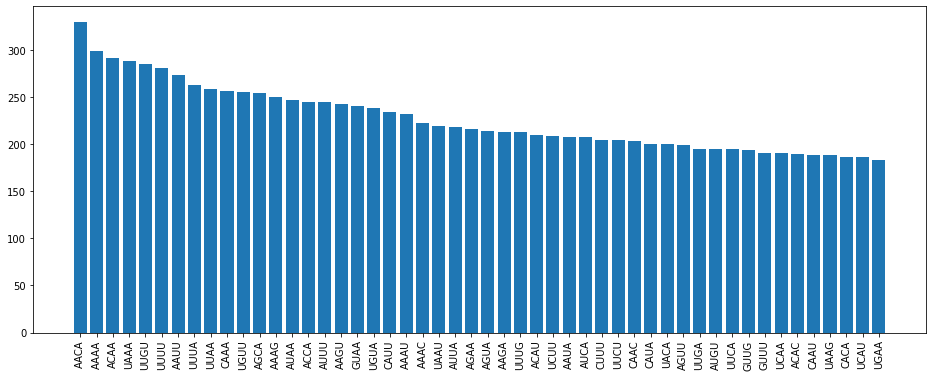

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

top_fourmers_sorted = sorted(list(fourmers.items()), key = lambda x: x[1])[::-1][0:50]
fourmers_frame = pd.DataFrame(top_fourmers_sorted, columns=["4-mer", "Count"]).set_index("4-mer")

f, ax = plt.subplots(figsize=(16,6))
plt.bar(fourmers_frame.index, fourmers_frame["Count"])
plt.xticks(rotation = 90)
plt.show()

## Part 4

Plot the frequency of all 64 3-mers, similarly sorted by
frequency.

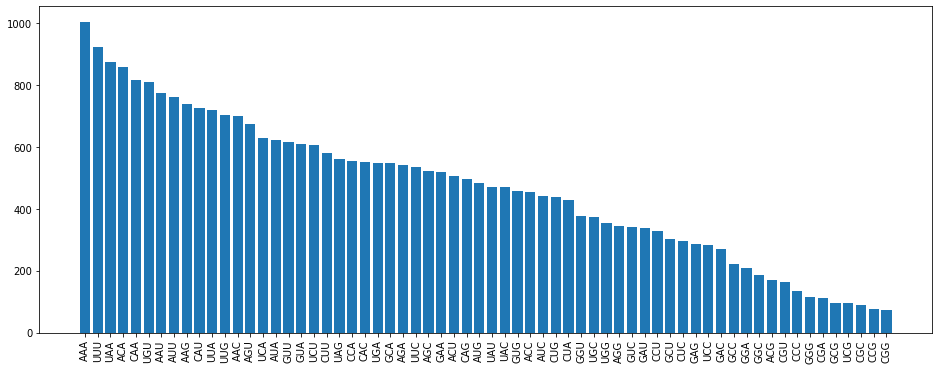

In [9]:
threemers_sorted = sorted(list(threemers.items()), key = lambda x: x[1])[::-1]
threemers_frame = pd.DataFrame(threemers_sorted, columns=["3-mer", "Count"]).set_index("3-mer")

f, ax = plt.subplots(figsize=(16,6))
plt.bar(threemers_frame.index, threemers_frame["Count"])
plt.xticks(rotation = 90)
plt.show()

# Translation

We have a transcriptome which contains the mRNA sequences expressed
by the virus, but we want to know the final protein sequences. Build a
new list of the proteins by converting each mRNA sequence to an amino
acid sequence. Print the amino acid sequence for the S protein.

In [10]:
#Ignoring stop codons
translation_dict = {
'TTT':'F', 'TCT':'S', 'TAT':'Y', 'TGT':'C',  
'TTC':'F', 'TCC':'S', 'TAC':'Y', 'TGC':'C',  
'TTA':'L', 'TCA':'S', 'TAA':'', 'TGA':'',  
'TTG':'L', 'TCG':'S', 'TAG':'', 'TGG':'W',
'CTT':'L', 'CCT':'P', 'CAT':'H', 'CGT':'R',
'CTC':'L', 'CCC':'P', 'CAC':'H', 'CGC':'R',  
'CTA':'L', 'CCA':'P', 'CAA':'Q', 'CGA':'R',  
'CTG':'L', 'CCG':'P', 'CAG':'Q', 'CGG':'R',  
'ATT':'I', 'ACT':'T', 'AAT':'N', 'AGT':'S',  
'ATC':'I', 'ACC':'T', 'AAC':'N', 'AGC':'S',   
'ATA':'I', 'ACA':'T', 'AAA':'K', 'AGA':'R',   
'ATG':'M', 'ACG':'T', 'AAG':'K', 'AGG':'R',   
'GTT':'V', 'GCT':'A', 'GAT':'D', 'GGT':'G',   
'GTC':'V', 'GCC':'A', 'GAC':'D', 'GGC':'G',   
'GTA':'V', 'GCA':'A', 'GAA':'E', 'GGA':'G', 
'GTG':'V', 'GCG':'A', 'GAG':'E', 'GGG':'G'}

translated_transcriptome = []
for sequence in transcriptome:
    seq_len = len(sequence)
    amino_list = []
    for i in range(0, seq_len-2, 3):
        #Per Piazza instructions, if we have a number of bases non-divisable by 3 (due to a frameshift) we cut off the extra bases
        if (i+3)%seq_len < i:
            continue
        codon = sequence[i:i+3]
        amino_list.append(translation_dict[codon])
    amino_string = ''.join(amino_list)
    translated_transcriptome.append(amino_string)
    
spike_protein_index = 1 #Found by manually opening the file and finding "Gene = S"
spike_protein = translated_transcriptome[spike_protein_index]
print(spike_protein)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

Make a bar chart of amino acid composition per transcript. You should
have a bar for each transcript (the x-axis), and you should have 20 stacked
bars, one for each amino acid.

To make this bar chart, we can leverage the Pandas package to create a `DataFrame` that makes the data amenable to a 1-line command for plotting.

This `DataFrame` should have the following structure:

In [13]:
# example DataFrame, your DataFrame should have the same exact columns
import pandas as pd

df = pd.DataFrame(columns=["Gene", "Position", "AA"])
df["Position"] = [1, 2, 3] * 3
df["Gene"] = ["Gene 1"] * 3 + ["Gene 2"] * 3 + ["Gene 3"] * 3
# random and just for example
df["AA"] = ["D", "T", "P"] + ["A", "B", "A"] + ["D", "A", "T"]

#df

This is called a **long-form** dataframe! Each gene is repeated many times in the gene column

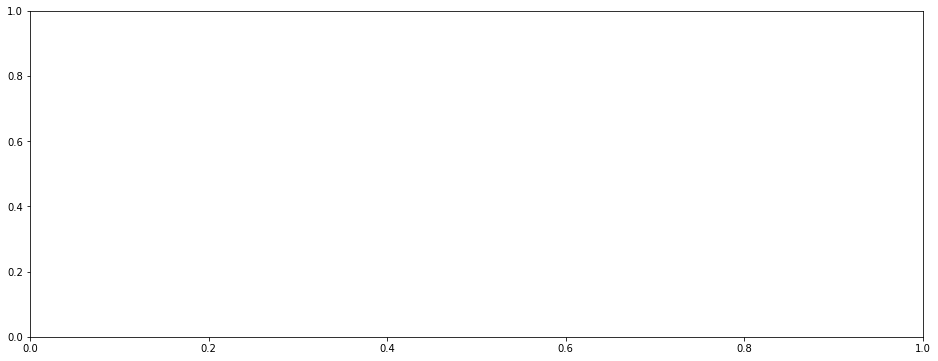

In [31]:
gene_frames = []
gene_num = 1
for gene in translated_transcriptome:
    aminos = [char for char in gene]
    indices = [i for i in range(len(aminos))]
    gene_name = ["Gene " + str(gene_num) for i in range(len(aminos))]
    
    new_frame = pd.DataFrame(columns=["Gene", "Position", "AA"])
    new_frame["Gene"] = gene_name
    new_frame["Position"] = indices
    new_frame["AA"] = aminos 
    
    gene_frames.append(new_frame)
    gene_num += 1

longform_frame = pd.concat(gene_frames)

#Chart produced is ugly, but kept it to stick with a "1-line command for plotting" as per the instructions
f, ax = plt.subplots(figsize=(16,6))
#chart = longform_frame.groupby("Gene").AA.value_counts(normalize=True).unstack().plot.bar(stacked=True)


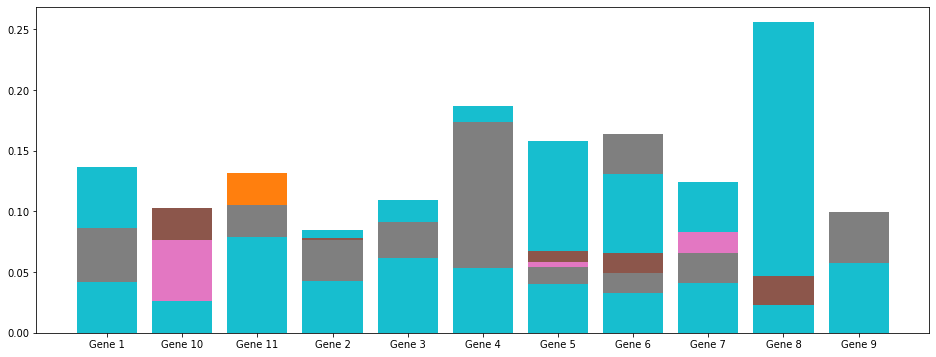

In [36]:
f, ax = plt.subplots(figsize=(16,6))
for col in grouped_longform.columns:
    plt.bar(grouped_longform.index, grouped_longform[col])

In [30]:
longform_frame

,Gene,Position,AA
0,Gene 1,0,M
1,Gene 1,1,E
2,Gene 1,2,S
3,Gene 1,3,L
4,Gene 1,4,V
...,...,...,...
33,Gene 11,33,N
34,Gene 11,34,F
35,Gene 11,35,N
36,Gene 11,36,L


In [41]:
grouped_longform = longform_frame.groupby("Gene").AA.value_counts(normalize=True).unstack()
grouped_longform.fillna(0, inplace=True)

In [42]:
grouped_longform

AA,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Gene,,,,,,,,,,,,,,,,,,,,
Gene 1,0.053437,0.030040,0.036395,0.041883,0.042605,0.045494,0.026719,0.061236,0.059792,0.136337,0.038417,0.049105,0.030907,0.038273,0.029752,0.067158,0.074235,0.086655,0.009821,0.041739
Gene 10,0.088305,0.000000,0.057279,0.028640,0.031026,0.102625,0.009547,0.033413,0.073986,0.064439,0.016706,0.052506,0.066826,0.083532,0.069212,0.088305,0.076372,0.019093,0.011933,0.026253
Gene 11,0.052632,0.026316,0.026316,0.000000,0.105263,0.026316,0.000000,0.078947,0.000000,0.105263,0.052632,0.131579,0.026316,0.026316,0.052632,0.052632,0.052632,0.105263,0.000000,0.078947
Gene 2,0.062058,0.031422,0.048704,0.037706,0.060487,0.064415,0.013354,0.059701,0.047918,0.084839,0.010998,0.069128,0.045562,0.048704,0.032993,0.077769,0.076198,0.076198,0.009427,0.042419
Gene 3,0.047273,0.025455,0.047273,0.040000,0.050909,0.050909,0.029091,0.076364,0.040000,0.109091,0.014545,0.029091,0.043636,0.032727,0.021818,0.080000,0.087273,0.090909,0.021818,0.061818
Gene 4,0.053333,0.040000,0.013333,0.026667,0.066667,0.013333,0.000000,0.040000,0.026667,0.186667,0.013333,0.066667,0.026667,0.000000,0.040000,0.106667,0.053333,0.173333,0.000000,0.053333
Gene 5,0.085586,0.018018,0.027027,0.031532,0.049550,0.063063,0.022523,0.090090,0.031532,0.157658,0.018018,0.049550,0.022523,0.018018,0.063063,0.067568,0.058559,0.054054,0.031532,0.040541
Gene 6,0.016393,0.000000,0.065574,0.081967,0.049180,0.000000,0.016393,0.163934,0.065574,0.131148,0.049180,0.065574,0.016393,0.049180,0.016393,0.065574,0.049180,0.049180,0.016393,0.032787
Gene 7,0.074380,0.049587,0.016529,0.066116,0.082645,0.033058,0.024793,0.066116,0.057851,0.123967,0.008264,0.016529,0.049587,0.041322,0.041322,0.057851,0.082645,0.066116,0.000000,0.041322
